In [1]:
from utils import *
from text_preprocessing import *
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

In [2]:
combined_df = preprocess_values(load_combined_df())
combined_df.head()


df shape:  (3000, 9)

rows with null values:  Int64Index([1551, 1552], dtype='int64')
rows that arent twitter:  1

dropped one row, fixed other null by dropping platform col, as unneeded

type of friends col:  int32

 country breakdown:  GB    2991
GG       5
JE       2
IM       1
Name: location.country, dtype: int64

df shape:  (2999, 8)


E:\Projects\bitbucket\fancy-a-challenge-william\utils.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  combined_df = pd.concat([csv_df,txt_df])


,author.properties.friends,author.properties.status_count,author.properties.verified,content.body,location.country,location.latitude,location.longitude,properties.sentiment
0,1689,22566.0,False,Can't believe I'm missing Love Island 😩,GB,51.570448,0.457135,1.0
1,114,1377.0,False,Last tweet about future wedding..... if I actu...,GB,52.969744,-1.172266,1.0
2,568,8375.0,False,"How many times does he wonna say the phrase ""i...",GB,51.394369,0.026299,-1.0
3,1845,19394.0,False,...even better if time travel were invented an...,GB,51.648544,-3.804292,-1.0
4,1617,17922.0,False,@GreenAlty @ShakeyStephens My Mum in mid 80s p...,GB,53.543471,-2.653238,0.0


Given the skewed nature of the data set, I have over sampled the neutral and positive tweets, to balance it.

In [3]:
combined_df['sentiment'] = combined_df['properties.sentiment'].apply(lambda x: 'neg' if x ==-1 else 'neut' if x==0 else "pos")
combined_df['sentiment'].dtype
combined_df[['properties.sentiment','sentiment']].head()

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

combined_df.shape
ros = RandomOverSampler(random_state=777)

X_ROS, y_ROS = ros.fit_sample(combined_df, combined_df['sentiment'])
ros_df = pd.DataFrame(X_ROS,columns=combined_df.columns)
ros_df['sentiment'].value_counts()

data_train,data_test = train_test_split(ros_df,test_size=0.3,random_state=37)


In [4]:
import numpy as np
import pandas as pd
import re

from bs4 import BeautifulSoup

import sys
import os
import csv

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Masking
from keras.layers import Dense, Input, Flatten,GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate
from keras.layers import Conv1D, GlobalMaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional,SpatialDropout1D
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping


MAX_SEQUENCE_LENGTH = 200
MAX_NB_WORDS = 20000
VALIDATION_SPLIT = 0.1

texts = data_train['content.body'].apply(lambda x: preprocess_no_variables(x))
#labels = data_train['sentiment']
labels = data_train['properties.sentiment']


Using TensorFlow backend.


To run this model it is necessary to have a glove embedding file in the root file.  If it is not there already,
this script will download it.  Beware this will add a one gigabyte file to your computer.

In [5]:
EMBEDDING_FILE = 'glove.6B.300d.txt'

if not os.path.exists(EMBEDDING_FILE):
    if not os.path.exists('glove.6B.zip'):
        ! wget http://nlp.stanford.edu/data/glove.6B.zip
    if not os.path.exists(EMBEDDING_FILE):
        ! unzip glove.6B.zip
        !rm glove.6B.100d.txt
        !rm glove.6B.50d.txt
        !rm glove.6B.200d.txt
    
import codecs

EMBEDDING_DIM = int(EMBEDDING_FILE.split('.')[-2][:-1])
EMBEDDING_DIM

300

In [6]:
embeddings_index = {}
f = open(os.path.abspath(EMBEDDING_FILE),encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


I have found it more effective to split the sentiment label into three binary columns using one hot encoding.

In [7]:
data_train['sent'] = data_train['properties.sentiment'].apply(lambda x: x + 1).astype('str')

from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
labels = onehotencoder.fit_transform(np.array(data_train['sent']).reshape(-1, 1)).toarray()


#just to check
sent_columns=['neg','neut','pos']
y_train = pd.DataFrame(x,columns=sent_columns)
assert(y_train[y_train.isnull().any(axis=1)].empty)
y_train.head()

c:\users\wburke\projects\venv36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,neg,neut,pos
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0


Here I have used preprocessing with removes completely uservariables and urls.  In another exercise, more could be
done to evaluate these, possibly look at domain names for example, but in the short run it is easier to ignore.

In [8]:
print('Shape of data tensor:', len(texts))
print('Shape of label tensor:', len(labels))

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print(data_test.shape)

test_texts= data_test['content.body'].apply(lambda x: preprocess_no_variables(x)).values

Shape of data tensor: 2946
Shape of label tensor: 2946


c:\users\wburke\projects\venv36\lib\site-packages\keras_preprocessing\text.py:177: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


(1263, 9)


In [9]:
test_tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
test_tokenizer.fit_on_texts(test_texts)
test_sequences = test_tokenizer.texts_to_sequences(test_texts)
test_word_index = test_tokenizer.word_index
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(test_data.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

(1263, 200)


In [10]:
EMBEDDING_DIM = 300
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print ('Length of embedding_matrix:', embedding_matrix.shape[0])
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            mask_zero=False,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)


print('Traing and validation set number of positive and negative reviews')
print (y_train.sum(axis=0))
print (y_val.sum(axis=0))

Length of embedding_matrix: 4947
Traing and validation set number of positive and negative reviews
[874. 895. 883.]
[103.  90. 101.]


In [11]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [16]:
import keras_metrics


sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
sentLayer = SpatialDropout1D(0.1)(embedded_sequences)
l_lstm = Bidirectional(LSTM(64, return_sequences=True))(sentLayer)
x = Bidirectional(GRU(64, return_sequences=True))(l_lstm)

x1 = Attention(MAX_SEQUENCE_LENGTH)(x)
x2 = GlobalAveragePooling1D()(x)
x3 = GlobalMaxPooling1D()(x)
x = Concatenate()([x1, x2, x3])

dense_1 = Dense(256,activation='relu')(x)
dropout_2=Dropout(0.15)(dense_1)
dense_2 = Dense(3, activation='softmax')(dropout_2)

model = Model(sequence_input, dense_2)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc',keras_metrics.precision(), keras_metrics.recall()])

model.summary()

ModuleNotFoundError: No module named 'keras_metrics'

In [13]:

filepath="data/predict-goal-weights.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)
callbacks_list = [checkpoint,early_stop]

history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=10, batch_size=32,shuffle=True,
                    callbacks=callbacks_list)

c:\users\wburke\projects\venv36\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 2652 samples, validate on 294 samples
Epoch 1/10
2652/2652 [==============================] - 88s 33ms/step - loss: 1.0345 - acc: 0.4729 - val_loss: 0.8299 - val_acc: 0.6565

Epoch 00001: val_acc improved from -inf to 0.65646, saving model to data/predict-goal-weights.best.hdf5
Epoch 2/10
2652/2652 [==============================] - 83s 31ms/step - loss: 0.8095 - acc: 0.6437 - val_loss: 0.7849 - val_acc: 0.6497

Epoch 00002: val_acc did not improve from 0.65646
Epoch 3/10
2652/2652 [==============================] - 92s 35ms/step - loss: 0.6401 - acc: 0.7485 - val_loss: 0.7555 - val_acc: 0.6429

Epoch 00003: val_acc did not improve from 0.65646
Epoch 4/10
2652/2652 [==============================] - 100s 38ms/step - loss: 0.5209 - acc: 0.7998 - val_loss: 0.5864 - val_acc: 0.7483

Epoch 00004: val_acc improved from 0.65646 to 0.74830, saving model to data/predict-goal-weights.best.hdf5
Epoch 5/10
2652/2652 [==============================] - 96s 36ms/step - loss: 0.4084 - acc: 0

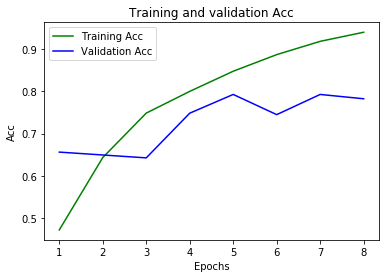

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

In [15]:
csvfile = open('output.csv', 'w') 
writer = csv.writer(csvfile)
writer.writerow(['statement','label'])

a=np.array(model.predict(test_data, batch_size=32, verbose=1))

label_names = ['negative','neutral','positive']

output=[]
for i in range(len(test_texts)):
    text = test_texts[i]
    label_col = label_names[np.argmax(a,axis=1)[i]]
    output_a=[text,label_col]
    output.append(output_a)
    print(label_col,':',text)
print(output)
model.save('data/sentiment-LSTM-Model.h5')
 
writer.writerows(output)
csvfile.close()

1263/1263 [==============================] - 11s 8ms/step
negative :   woof exclamation
neutral : video will be in the morning now
neutral : if you ever gonna sleep at mine just know we are gonna watch joan rivers do not start with me so sexy is not it
positive : feel like this was created just for you  
neutral : imagine been able to tweet about something fun nope not me have no idea exclamation i am so boring face with tears of joy face with tears of joy
positive :  i am on page # this month exclamation
positive : gee's little laugh is adorable sparkles smiling face see no evil monkey
negative : my mood is pile of poo
positive : when  makes the whole house watch the drivel that is skull skull
negative :  yes then jack congrats on #zerozerok well done
neutral :   it does not matter how they became that way telling them oh its okay is only going to make it worse
negative :  ha ha blush
neutral : there are places i will not work because of this important that we acknowledge the past 
ne

neutral :  and that will be more than fine happy
positive : lorna laidlaw    sun # july 
positive : scottish song stories n dance # wee ones inc brochan lon an interactive spurtle happy in the app launchd #day 
neutral : 
negative : this look back at euro ## is getting me very excited for the euros
positive : one## baby this ride is just getting started
negative : finally got round to watching enjoyed it exclamation thumbs up interesting adding a dirt track to the top gear track
negative :  when do you finish
positive : hey rob hope all's good exclamation check out  went tonight think you will be a fan tomato mushroom melon seedling smiling face x 
neutral :  i am ok thanks have you had a good day xx
neutral : i have watched too many series over this past few weeks
neutral :  bruv 
positive : great volume form mr faze grinning face with smiling eyes 
negative : should i expose 
neutral : hay transmisin hoy
neutral :  i would acc cry so much if i got it soccer ball folded hands folded h

negative : i want a bubble wrap dress
negative :   and free ale clinking beer mugs
neutral : 
neutral : 
positive : tell em exclamation exclamation 
positive :  haha i have retired remember retired from going out
positive : i like chicken with a shitty smell that is why i love cluckin bell face with tears of joy face with tears of joy
neutral :  i like the last bit
negative : need a terrific dell monitor by friday
negative : how pretty is  smiling face with heart eyes my fave
positive :  what some people will do to make money
negative : always knew it was never going to happen
negative : welcome to our new followers on the #onest      
neutral : watch this video of gorillas beating whilst you lock into my show thats live on  right now exclamation 
neutral : standard gig pic surrounded by one#yr old girls singing 
neutral :   signed already shared rt'd x
negative : luuciidity coome back to mee
neutral : they are far from the finished article but what a fascinating prospect that was a re

neutral :  an hour hour and a half at the most with a wee encore that is enough for me
negative :  #th apparently
negative : should i expose 
neutral :   that is what doctors and midwives say the first one# weeks are you gotta be careful stage of pregnancy xx
negative :  i am back now love exclamation are you face blowing a kiss xx
positive :  he is doing a good job for brexit though
positive :  if you ever did i will cry n you do not want me to smiling face with smiling eyes
negative :  in english law defamation is the general terms slander is for spoken stuff libel for published stuff not my area of law
negative : fuck you quite literally
positive :  still going on about this
negative :  server wont come on but tagging 
neutral : that shower was the best omg
negative :  at east pitforthie dairy farm dd# #pq this sunday oneone # all welcome come and see in action
negative :   they are so lucky exclamation
negative : # yo's bedtime reading attack of the demon dinner ladies    
positive

In [ ]:
data_test['sent'] = data_train['properties.sentiment'].apply(lambda x: x + 1).astype('str')

labels_test = onehotencoder.fit_transform(np.array(data_train['sent']).reshape(-1, 1)).toarray()
